In [1]:
import os

import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp
import scipy.ndimage as ndi

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import kinematics as kin

In [2]:
Xe_migdal = mc.migdalcalc(target="Xe-131", nuclear_data_name="jendl40")

In [3]:
def interp_csv(file_name, skip_header=0):
    plot_data = np.genfromtxt(file_name, delimiter=',', skip_header=skip_header)
    x = list(zip(*plot_data))[0]
    y = list(zip(*plot_data))[1]
    
    return interp.interp1d(x, y, bounds_error=False, fill_value = 0, kind='linear')

In [4]:
A = Xe_migdal.A
N_per_kg = (6.02e26/A)
barns_to_cm2 = 1e-24
flux = 100 #nuetrons/cm^2/second

xsec_to_inv_kg_seconds = flux*N_per_kg*barns_to_cm2

In [5]:
En_range = np.geomspace(1e3, 1e6, 3000)
migdal_xsec_arr = []

for En in En_range:
    migdal_spectrum = Xe_migdal.dR_dDeltaE_HS(En, flux=xsec_to_inv_kg_seconds)
    
    dE_range = np.geomspace(1e-3, kin.DeltaE_Max(Xe_migdal.A, En), 1001)
    samples = migdal_spectrum(dE_range)
    
    migdal_xsec = integrate.trapezoid(samples, dE_range)
    migdal_xsec_arr.append(migdal_xsec)
    
bell_migdal = interp_csv('./input/bell/migdal.csv')
bell_pts = bell_migdal.x

bell_elastic = interp_csv('./input/bell/elastic.csv')

duncan_elastic = lambda En: xsec_to_inv_kg_seconds*Xe_migdal.nuc.SIG(En)
duncan_migdal = interp.interp1d(En_range, migdal_xsec_arr, bounds_error=False, fill_value = 0, kind='linear')

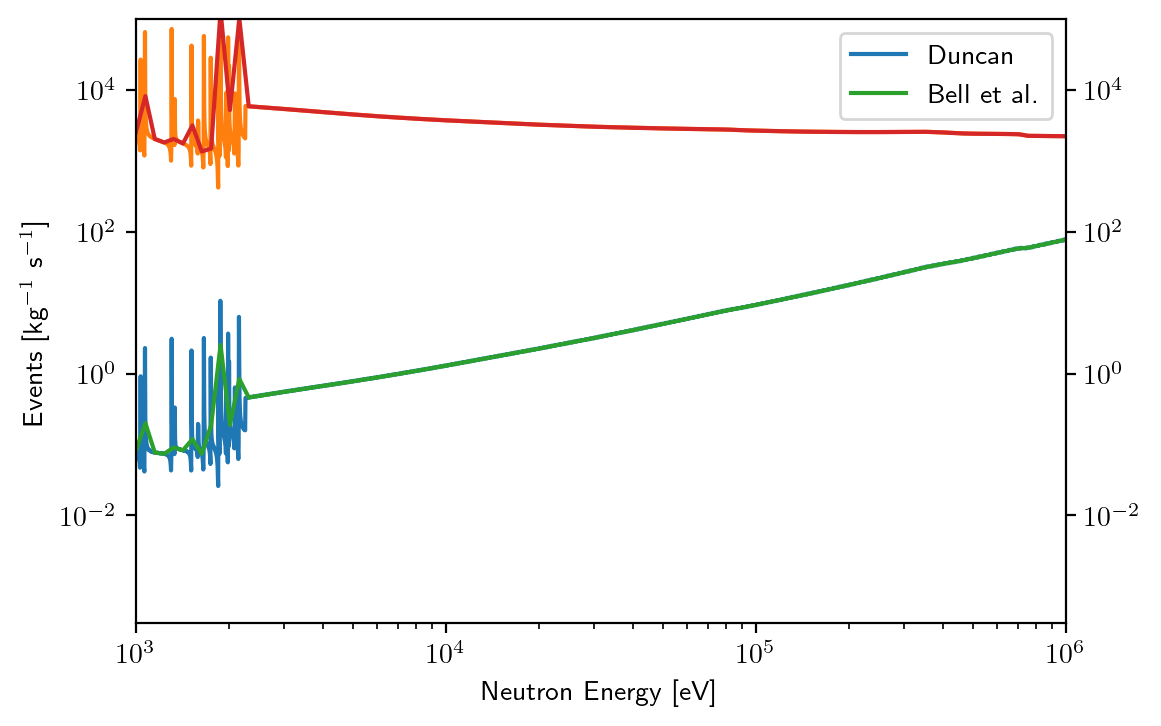

In [6]:
plt.plot(En_range, migdal_xsec_arr, label="Duncan")
plt.plot(En_range, duncan_elastic(En_range))
plt.plot(np.multiply(bell_pts, 1e3), bell_migdal(bell_pts), label="Bell et al.")
plt.plot(np.multiply(bell_pts, 1e3), bell_elastic(bell_pts))
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Neutron Energy [eV]')
plt.ylabel(r'Events [kg$^{-1}$ s$^{-1}$]')
plt.tick_params(labelright=True, right=True)
plt.ylim(3e-4, 1e5)
plt.xlim(1e3, 1e6)
plt.show()